In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

import gensim



import nltk
from collections import defaultdict

from xgboost import XGBClassifier

import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from micromort.datasets.risk_dataset import RiskDataset
from gensim.models import KeyedVectors

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Get the data

In [124]:
data = pd.read_csv( "../../data/annotator_data_dump_with_text").drop(["Unnamed: 0", "Unnamed: 0.1"],axis=1)

In [125]:
data = data[data.text.notnull()]

In [108]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        model = gensim.models.KeyedVectors.load_word2vec_format("../../data/wordEmbeddings/word2vec-GoogleNews-vectors/GoogleNews-vectors-negative300.bin", binary=True)
        #model = KeyedVectors.load_word2vec_format("/home/mannu/data/wordEmbeddings/word2v.txt")
        #gensim.models.Word2Vec.load("/home/mannu/data/wordEmbeddings/word2v.txt")
        return model
    
    print('{} not found. training model'.format(location))
    model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [12]:
w2v = get_word2vec("", "../../data/wordEmbeddings/glove.6B.300d.txt")

Found ../../data/wordEmbeddings/glove.6B.300d.txt


In [109]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [126]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2v)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


In [201]:
train, test, y_train, y_val = sklearn.model_selection.train_test_split(data, data["category"].values)

In [202]:
train["full"] = train["title"] + " " + train["text"]
test["full"] = test["title"] + " " + test["text"]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [203]:
class_mapping = {
91: 'health', 92: 'safety_security', 93 : 'environment',
                      94 : 'social_relations', 95 : 'meaning_in_life', 96 : 'achievement',
                      97 : 'economics', 98 : 'politics', 99 : 'not_applicable'}
X_train = train['full'].values
X_val = test['full'].values

In [204]:
len(y_train),len(X_train), len(X_val), len(y_val)

(1355, 1355, 452, 452)

In [205]:
for index, y in enumerate(y_val):
    y_val[index] = eval(y)    

In [206]:
for index, y in enumerate(y_train):
    y_train[index] = eval(y)    

In [207]:
for index, y in enumerate(y_train):
    for _index, _y in enumerate(y):
        y[_index] = int(_y)
for index, y in enumerate(y_val):
    for _index, _y in enumerate(y):
        y[_index] = int(_y)

In [208]:
_X_val = []
_y_val = []
for index, y in enumerate(y_val):
    if y == [0]:
        continue
    else:
        new_y = []
        for _y in y:
            if _y != -1:
                new_y.append(_y)
        _y_val.append(new_y)
        _X_val.append(X_val[index].decode('utf-8').strip())

        
_X_train = []
_y_train = []
for index, y in enumerate(y_train):
    if y == [0]:
        continue
    else:
        new_y = []
        for _y in y:
            if _y != -1:
                new_y.append(_y)
        _y_train.append(new_y)
        _X_train.append(X_train[index].decode('utf-8').strip())

In [209]:
len(_y_train),len(_X_train), len(_X_val), len(_y_val)

(1350, 1350, 451, 451)

In [210]:
X_train = _X_train
X_val = _X_val
y_train = _y_train
y_val = _y_val

In [211]:
mlb = MultiLabelBinarizer(classes=sorted(class_mapping.keys()))
y_train = mlb.fit_transform(_y_train)
y_val = mlb.fit_transform(_y_val)

In [212]:
mean_embedded_train = mean_embedding_vectorizer.fit_transform(X_train)
mean_embedded_test = mean_embedding_vectorizer.fit_transform(X_val)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [213]:
print(mean_embedded_train.shape, mean_embedded_test.shape)

((1350, 300), (451, 300))


In [224]:
def accuracy_score_ml(pred,gd):
    n = len(pred)
    score = 0.0
    for i in range(0,n):
        d = {}
        for label in pred[i]:
            d[label] = 1
        for label in gd[i]:
            if label in d:
                d[label] = 2
            else:
                d[label] = 1
        temp = 0
        for ky in d.keys():
            if d[ky] == 2:
                temp = temp+1
        score = score + float(temp)/len(d.keys())
    return score/n

In [219]:
classifier = OneVsRestClassifier(LinearSVC(random_state=0))
y_pred_svm = classifier.fit(mean_embedded_train, y_train).predict(mean_embedded_test)

TypeError: argument of type 'int' is not iterable

In [225]:
accuracy_score_ml(y_val, y_pred_svm)

0.8691796008869179

In [167]:
from micromort.utils.classification_plotter import plot_classification_report

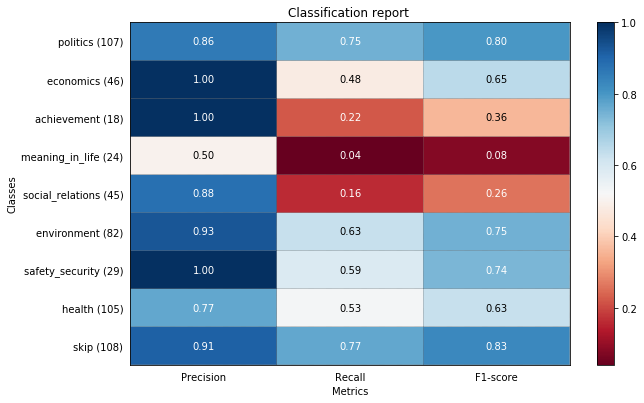

In [216]:
plot_classification_report(sklearn.metrics.classification_report(y_val, y_pred_svm, target_names= [ 'skip',
'health','safety_security',  'environment', 'social_relations', 'meaning_in_life', 'achievement', 
'economics',  'politics', 'not_applicable']))

## Try tfidf-embeddings

In [169]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.wv.syn0[0])

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y=None):
        return self.transform(X)



class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.wv.syn0[0])
        print(self.dim)

    def fit(self, X):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec.wv] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [170]:
#_ = MyTokenizer().fit_transform(X_train)
_[0]

IndexError: invalid index to scalar variable.

In [171]:
tfidf_embedding_vectorizer = TfidfEmbeddingVectorizer(w2v)
tfidf_embedding_vectorizer.fit(X_train)
tfidf_embedded_train = tfidf_embedding_vectorizer.transform(X_train)
tfidf_embedded_test = tfidf_embedding_vectorizer.transform(X_val)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).


300


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [172]:
classifier = OneVsRestClassifier(LinearSVC(random_state=0))
y_pred_svm = classifier.fit(tfidf_embedded_train, y_train).predict(tfidf_embedded_test)
accuracy_score(y_val, y_pred_svm)

0.47216035634743875